# Explore road network

- Query road type networks using OSMnx
- Generate statistics
- Compare road types by length for different AOIs
- Plot road type networks for visual comparison

In [1]:
import sys
import yaml
from pathlib import Path

import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import osmnx as ox
import pandas as pd
import seaborn as sns
from ohsome import OhsomeClient

datetime = '2024-03-15T00:00:00Z'

ox.settings.use_cache=False
ox.settings.log_console=True
ox.settings.overpass_settings = f'[out:json][date: "{datetime}"]'

data_dir = Path('../data')
out_dir = Path('../outdir')

## Area of Interest

In [2]:
aoi_gdf = gpd.read_file(data_dir / 'MA-HD-RNK.geojson')
aoi_bpoly = aoi_gdf.to_json()

## Query road network with OSMnx

In [3]:
with open(data_dir  / 'road_network_asset.yaml', 'r') as src:
    asset = yaml.safe_load(src)
    road_types = asset['road_types']

In [4]:
graphs = {}

for road_type in road_types:
    try:
        graphs[road_type] = ox.graph_from_polygon(aoi_gdf.unary_union, network_type='all', simplify=False, retain_all=True, custom_filter=f'["highway"~"{road_type}"]')
    except Exception:
        print(f'No features found for {road_type}')
        continue

## Calculate road network statistics

In [5]:
def calculate_stats(graphs):
    # Initialize an empty DataFrame to store the stats
    stats_df = pd.DataFrame()

    for road_type, graph in graphs.items():
        # Calculate basic stats for the graph
        stats = ox.basic_stats(graph, 100)

        # Convert the stats to a DataFrame
        stats_df_temp = pd.DataFrame(stats, index=[road_type])

        # Concatenate the DataFrame with the main DataFrame
        stats_df = pd.concat([stats_df, stats_df_temp])

    # Sort the columns alphabetically
    stats_df = stats_df.sort_index(axis=1)

    return stats_df

# Call the function
stats_df = calculate_stats(graphs)

In [6]:
stats_df.sort_index(axis=1)

,circuity_avg,edge_density_km,edge_length_avg,edge_length_total,intersection_count,intersection_density_km,k_avg,m,n,node_density_km,self_loop_proportion,street_density_km,street_length_avg,street_length_total,street_segment_count,streets_per_node_avg,streets_per_node_counts,streets_per_node_proportions
motorway,1.0,3.258497e+09,47.006587,3.258497e+05,6674,6.674000e+07,2.036428,6932,6808,6.808000e+07,0.0,3.248213e+09,47.288003,324821.290,6869,2.021445,NaN,NaN
motorway_link,1.0,8.006333e+08,20.361986,8.006333e+04,3670,3.670000e+07,1.999491,3932,3933,3.933000e+07,0.0,7.903496e+08,20.427749,79034.961,3869,1.968980,NaN,NaN
trunk,1.0,1.073560e+09,29.149053,1.073560e+05,3416,3.416000e+07,2.072011,3683,3555,3.555000e+07,0.0,1.032797e+09,28.970450,103279.653,3565,2.006751,NaN,NaN
trunk_link,1.0,3.164634e+08,15.444775,3.164634e+04,1867,1.867000e+07,1.963584,2049,2087,2.087000e+07,0.0,3.079507e+08,15.343833,30795.073,2007,1.923335,NaN,NaN
primary,1.0,4.791816e+09,29.588244,4.791816e+05,11236,1.123600e+08,2.841477,16195,11399,1.139900e+08,0.0,3.124016e+09,26.639520,312401.649,11727,2.058953,NaN,NaN
secondary,1.0,9.939541e+09,26.843309,9.939541e+05,21688,2.168800e+08,3.370011,37028,21975,2.197500e+08,0.0,5.525709e+09,24.650738,552570.949,22416,2.041547,NaN,NaN
tertiary,1.0,9.971112e+09,23.796267,9.971112e+05,23069,2.306900e+08,3.564762,41902,23509,2.350900e+08,0.0,5.332683e+09,22.506471,533268.323,23694,2.016972,NaN,NaN
unclassified,1.0,7.166686e+09,28.233082,7.166686e+05,13195,1.319500e+08,3.549217,25384,14304,1.430400e+08,0.0,3.750574e+09,26.667901,375057.358,14064,1.967771,NaN,NaN
cycleway,1.0,1.502812e+09,18.557812,1.502812e+05,4081,4.081000e+07,3.155270,8098,5133,5.133000e+07,0.0,8.509119e+08,18.185764,85091.188,4679,1.823300,NaN,NaN
footway,1.0,2.626066e+10,14.004789,2.626066e+06,70735,7.073500e+08,3.741149,187512,100243,1.002430e+09,0.0,1.321576e+10,14.047220,1321576.500,94081,1.877089,NaN,NaN


In [7]:
columns_to_drop = ['circuity_avg', 'edge_density_km', 'edge_length_avg', 'edge_length_total', 'intersection_count', 'intersection_density_km', 'k_avg', 'm', 'n', 'node_density_km', 'self_loop_proportion', 'streets_per_node_avg', 'streets_per_node_counts', 'streets_per_node_proportions']

stats_df.drop(columns=[col for col in columns_to_drop if col in stats_df.columns], inplace=True)

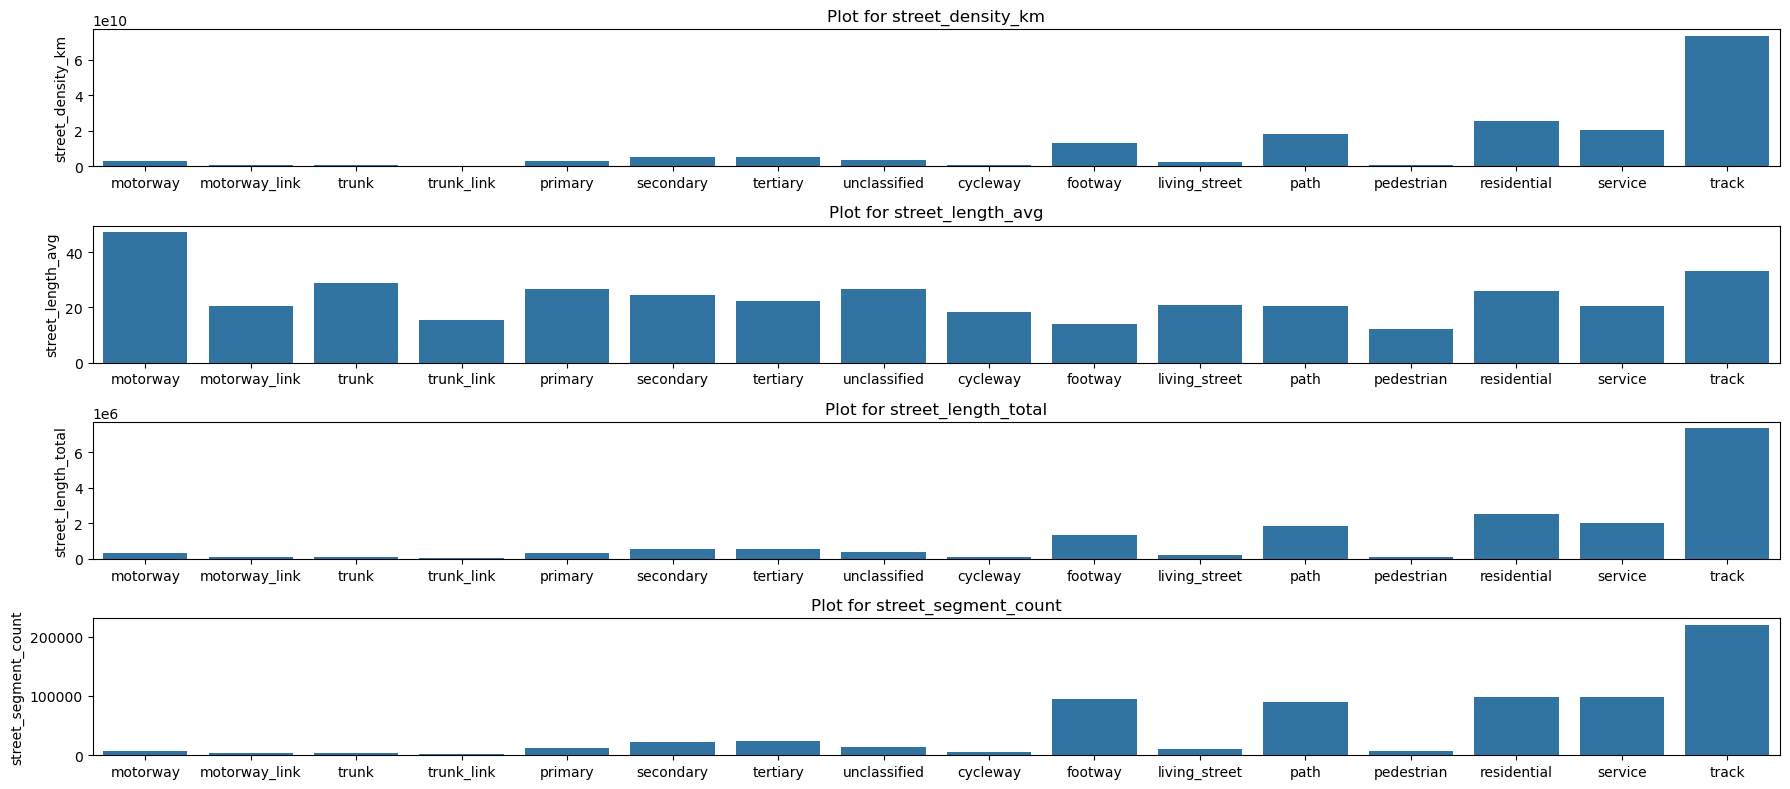

In [8]:
metrics = stats_df.columns

fig, axs = plt.subplots(len(metrics), 1, figsize=(18, 2*len(metrics)))

for i, metric in enumerate(metrics):
    g = sns.barplot(data=stats_df, x=stats_df.index, y=metric, ax=axs[i])
    g.set_xlabel('')
    axs[i].set_title(f'Plot for {metric}')

plt.tight_layout()
plt.show()

## Explore road lengths

### Query from Ohsome API - Test small (MA-HD-RNK)

In [3]:
aoi_gdf = gpd.read_file(data_dir / 'MA-HD-RNK.geojson')
aoi_bpoly = aoi_gdf.to_json()

In [4]:
client = OhsomeClient()

responses = []
try:
    response = client.elements.geometry.post(
        bpolys = aoi_bpoly, 
        filter = 'highway=* and type:way and geometry:line',
        time = datetime,
        properties = 'tags'
    )
    road_network_gdf = response.as_dataframe()
except Exception as err:
    print(f'Could not send request to ohsome API: {err}')
    sys.exit()

In [5]:
road_network_gdf.to_crs(epsg=25832, inplace=True)

### Rank lengths of road types

In [6]:
# Calculate the length of each feature
road_network_gdf['road_length'] = road_network_gdf['geometry'].length / 1000

# Calculate total length for each 'highway' type
total_length_per_highway = road_network_gdf.groupby('highway')['road_length'].sum()

total_length_per_highway.sort_values(ascending=False)

highway
track            7374.110236
residential      2539.511990
service          2016.648411
path             1856.027635
footway          1318.572988
secondary         534.404834
tertiary          530.990433
unclassified      376.172879
primary           282.079666
motorway          247.477656
living_street     230.635014
cycleway           85.125568
motorway_link      79.269194
trunk              72.875161
pedestrian         31.853335
trunk_link         30.829289
Name: road_length, dtype: float64

In [7]:
# Calculate total length
total_length = total_length_per_highway.sum()
print('Total length:', round(total_length, 2))

# Calculate the proportion of each 'highway' type
proportion_per_highway = round((total_length_per_highway / total_length) * 100, 3)

# Sort the result
proportion_per_highway.sort_values(ascending=False)

Total length: 17606.58


highway
track            41.883
residential      14.424
service          11.454
path             10.542
footway           7.489
secondary         3.035
tertiary          3.016
unclassified      2.137
primary           1.602
motorway          1.406
living_street     1.310
cycleway          0.483
motorway_link     0.450
trunk             0.414
pedestrian        0.181
trunk_link        0.175
Name: road_length, dtype: float64

In [8]:
counts_df = pd.DataFrame(list(proportion_per_highway.items()), columns=['road_type', 'mahdrnk'])

### Query from Ohsome API - Trier-Saarburg

In [15]:
aoi_gdf = gpd.read_file(data_dir / 'Trier-Saarburg.geojson')
aoi_bpoly = aoi_gdf.to_json()

In [16]:
client = OhsomeClient()

responses = []
try:
    response = client.elements.geometry.post(
        bpolys = aoi_bpoly, 
        filter = 'highway=* and type:way and geometry:line',
        time = datetime,
        properties = 'tags'
    )
    road_network_gdf = response.as_dataframe()
except Exception as err:
    print(f'Could not send request to ohsome API: {err}')
    sys.exit()

In [17]:
road_network_gdf.to_crs(epsg=25832, inplace=True)

### Rank lengths of road types

In [18]:
# Calculate the length of each feature
road_network_gdf['road_length'] = road_network_gdf['geometry'].length

# Calculate total length for each 'highway' type
total_length_per_highway = road_network_gdf.groupby('highway')['road_length'].sum()

# Calculate total length
total_length = total_length_per_highway.sum()
print('Total length:', round(total_length, 2))

# Calculate the proportion of each 'highway' type
proportion_per_highway = round((total_length_per_highway / total_length) * 100, 3)

# Sort the result
proportion_per_highway.sort_values(ascending=False)

highway
track             58.009
residential        9.347
path               8.543
service            6.410
tertiary           4.400
secondary          3.209
footway            3.112
primary            2.359
unclassified       2.030
motorway           0.978
living_street      0.434
trunk              0.271
steps              0.206
motorway_link      0.171
primary_link       0.110
proposed           0.077
pedestrian         0.077
cycleway           0.075
construction       0.056
trunk_link         0.048
secondary_link     0.039
raceway            0.015
tertiary_link      0.015
bridleway          0.006
road               0.002
platform           0.001
bus_stop           0.000
disused            0.000
corridor           0.000
via_ferrata        0.000
Name: road_length, dtype: float64

In [19]:
proportion_df = pd.DataFrame(proportion_per_highway.items(), columns=['road_type', 'trsb'])
counts_df = counts_df.merge(proportion_df, on='road_type', how='left')

### Query from Ohsome API - Lodzkie

In [20]:
aoi_gdf = gpd.read_file(data_dir / 'Lodzkie.geojson')
aoi_bpoly = aoi_gdf.to_json()

In [21]:
client = OhsomeClient()

responses = []
try:
    response = client.elements.geometry.post(
        bpolys = aoi_bpoly, 
        filter = 'highway=* and type:way and geometry:line',
        time = datetime,
        properties = 'tags'
    )
    road_network_gdf = response.as_dataframe()
except Exception as err:
    print(f'Could not send request to ohsome API: {err}')
    sys.exit()

In [22]:
road_network_gdf.to_crs(epsg=25832, inplace=True)

### Rank lengths of road types

In [23]:
# Calculate the length of each feature
road_network_gdf['road_length'] = road_network_gdf['geometry'].length

# Calculate total length for each 'highway' type
total_length_per_highway = road_network_gdf.groupby('highway')['road_length'].sum()

# Calculate total length
total_length = total_length_per_highway.sum()

# Calculate the proportion of each 'highway' type
proportion_per_highway = round((total_length_per_highway / total_length) * 100, 3)

# Sort the result
proportion_per_highway.sort_values(ascending=False)

highway
footway           21.607
service           17.425
track             16.722
residential       16.551
path               7.982
tertiary           6.572
unclassified       3.496
secondary          2.019
proposed           1.594
cycleway           1.398
primary            1.225
motorway           0.940
living_street      0.882
trunk              0.766
motorway_link      0.172
construction       0.124
trunk_link         0.115
steps              0.102
pedestrian         0.087
primary_link       0.072
secondary_link     0.043
tertiary_link      0.040
corridor           0.025
bridleway          0.024
raceway            0.014
platform           0.003
Name: road_length, dtype: float64

In [24]:
proportion_df = pd.DataFrame(proportion_per_highway.items(), columns=['road_type', 'lodzkie'])
counts_df = counts_df.merge(proportion_df, on='road_type', how='left')

In [25]:
counts_df['mean'] = counts_df[['mahdrnk', 'trsb', 'lodzkie']].mean(axis=1)
counts_df.sort_values(by='mean', ascending=False)

,road_type,mahdrnk,trsb,lodzkie,mean
27,track,41.344,58.009,16.722,38.691667
19,residential,14.238,9.347,16.551,13.378667
22,service,11.307,6.410,17.425,11.714000
7,footway,7.393,3.112,21.607,10.704000
11,path,10.406,8.543,7.982,8.977000
25,tertiary,2.977,4.400,6.572,4.649667
20,secondary,2.996,3.209,2.019,2.741333
30,unclassified,2.109,2.030,3.496,2.545000
14,primary,1.582,2.359,1.225,1.722000
9,motorway,1.388,0.978,0.940,1.102000


## Plot road types for spatial distribution

In [32]:
aoi_gdf = gpd.read_file(data_dir / 'MA-HD-RNK.geojson')
aoi_bpoly = aoi_gdf.to_json()

In [33]:
road_types_filter = ','.join([f'{road_type}' for road_type in road_types])

In [34]:
client = OhsomeClient()

responses = []
try:
    response = client.elements.geometry.post(
        bpolys = aoi_bpoly, 
        filter = f'highway in ({road_types_filter}) and type:way and geometry:line',
        time = datetime,
        properties = 'tags'
    )
    road_network_gdf = response.as_dataframe()
except Exception as err:
    print(f'Could not send request to ohsome API: {err}')
    sys.exit()